# This code will train the model and save weights  using a data generator

First Import libraries

In [1]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [3]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [4]:
def gather_set_and_path(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(str(data_path+f))
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

## Expected Dimmentions

Image: (512,512) range: 0:255

Label: (512,512) range: 0:1

In [5]:
data_path_1 = r"C:\Users\UAB\data\KU\data\\"
data_path_2 = r"C:\Users\UAB\data\Mayo\data\\"
data_path_3 = r"C:\Users\UAB\data\Emory\data\\"
data_path_4 = r"C:\Users\UAB\data\UAB\data\\"

images_1 = gather_set_and_path(data_path_1, '_M')
images_2 = gather_set_and_path(data_path_2, '_M')
images_3 = gather_set_and_path(data_path_3, '_M')
images_4 = gather_set_and_path(data_path_4, '_M')


images = images_1+images_2+images_3+images_4


print(len(images))



77885


In [6]:
print(len(images_1))
print(len(images_2))
print(len(images_3))
print(len(images_4))


26082
21037
23488
7278


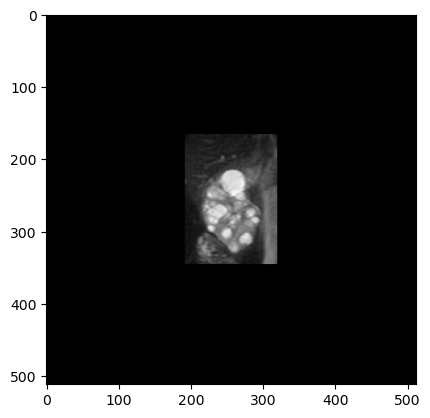

In [7]:
%matplotlib inline

image = np.load(images[-150])
plt.imshow(image, cmap='gray')

In [8]:
masks_1 = gather_set_and_path(data_path_1, '_K')
masks_2 = gather_set_and_path(data_path_2, '_K')
masks_3 = gather_set_and_path(data_path_3, '_K')
masks_4 = gather_set_and_path(data_path_4, '_K')

masks = masks_1 + masks_2 + masks_3 + masks_4

print(len(masks))

77885


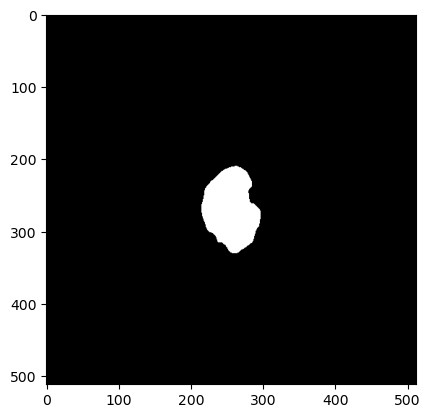

In [9]:
mask = np.load(masks[-150])
plt.imshow(mask, cmap='gray')

In [10]:

labels_1 = gather_set_and_path(data_path_1, '_C')
labels_2 = gather_set_and_path(data_path_2, '_C')
labels_3 = gather_set_and_path(data_path_3, '_C')
labels_4 = gather_set_and_path(data_path_4, '_C')

labels = labels_1 + labels_2 + labels_3 + labels_4

print(len(labels))


78257


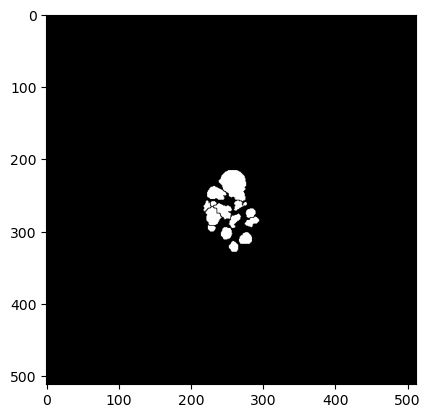

In [11]:
label = np.load(labels[-150])
plt.imshow(label, cmap='gray')

In [12]:
print(masks[-1500])
print(images[-1500])
print(labels[-1500])
test_img = np.load(images[100])
print(test_img.shape, test_img.max(), test_img.min())
test_msk = np.load(masks[100])
print(test_msk.shape, test_msk.max(), test_msk.min())
test_lab = np.load(labels[100])
print(test_lab.shape, test_lab.max(), test_lab.min())


C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_K.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_M.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_C.npy
(512, 512) 239 0
(512, 512) 1 0
(512, 512) 1 0


## Define Image and Label ID for data generator

Here the "test train split" will need to be replaced so we have the whole patient in one or the other"


In [13]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [14]:
print(len(labels))

77885


In [15]:
import os
img_name = os.path.basename(images[0])[0:11]
print(img_name)

KU_101934_0


## Image separation for entire patient in training or validation - use with single set of images


In [50]:
from sklearn.model_selection import train_test_split


id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:11]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [51]:
print(len(unique_ids))

350


In [52]:
train, val = train_test_split(unique_ids, train_size = 0.8)

In [53]:
print(len(train))
print(len(val))

280
70


In [54]:
print(train[0:2])

['MA_323837_7', 'EM_271043_3']


In [55]:
#use this when images do not contain filepath:
#train_list = [image for image in images if image[0:8] in train]
#val_list = [image for image in images if image[0:8] in val] 

In [56]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train):
        train_list.append(images[i])

In [57]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val):
        val_list.append(images[i])

In [58]:
print(len(train_list))
print(len(val_list))
print(len(train_list)+len(val_list))
print(len(images))

62241
15644
77885
77885


In [59]:
partition = {'train':train_list, 'validation':val_list}

# Use for given csv file


In [16]:
import pandas as pd
df = pd.read_excel (r"C:\Users\UAB\Kidney-Segmentation-Jupyter\Data for AI development.xlsx", engine='openpyxl')

In [17]:
df = df.iloc[1: , 0:4]
df. columns=df. iloc[0] 

In [18]:
df2 = df.filter(regex='Validation')
df2 = df2.iloc[:,0].dropna()
val_csv_list = df2.values.tolist()
val_csv_list = val_csv_list[1:]

In [19]:
df3 = df.filter(regex='Training')
df3 = df3.iloc[:,0].dropna()
train_csv_list = df3.values.tolist()
train_csv_list = train_csv_list[1:]

In [20]:
print(len(train_csv_list))
print(train_csv_list[0])
print(len(val_csv_list))
print(val_csv_list[0])

151
439240L
19
419258L


In [21]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [22]:
id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:17]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [23]:
train_sets=[]
for i in range(len(train_csv_list)):
    phrase1 = train_csv_list[i][:-2]
    phrase2 = train_csv_list[i][-1]
    #print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                train_sets.append(name)
            else:
                continue
        else:
            continue

In [24]:
val_sets=[]
for i in range(len(val_csv_list)):
    phrase1 = val_csv_list[i][:-2]
    phrase2 = val_csv_list[i][-1]
    print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                val_sets.append(name)
            else:
                continue
        else:
            continue

41925 L
41925 R
26434 R
26517 L
26517 R
27168 L
27168 R
28393 L
37468 R
37625 L
37625 R
38016 L
17079 L
17079 R
17320 L
17320 R
17875 L
17875 R
18341 L


In [25]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [26]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])

In [30]:
print(len(train_list))
print(len(val_list))

60327
8516


In [28]:
partition = {'train':train_list, 'validation':val_list}

## Use for crossfold validation:

In [27]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [28]:
train_sets = ['MA_', 'KU_', "EM_"]
val_sets = ["UB_"]

train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [29]:
print(train_list[100])

C:\Users\UAB\data\Emory\data\\EM_200922_0_144_L_60_M.npy


In [30]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])


In [31]:
print(val_list[100])

C:\Users\UAB\data\UAB\data\\UB_407132_0_95_R_14_M.npy


In [32]:
partition = {'train':train_list, 'validation':val_list}
print(len(train_list))
print(len(val_list))

23488
7278


# Create our data generators 

In [31]:

from Data_Gen_Mask_PREDICTION import DataGeneratorK

In [32]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 2,
          'shuffle': True}
training_generator = DataGeneratorK(partition['train'], labels, **params)
validation_generator = DataGeneratorK(partition['validation'], labels, **params)

In [33]:
X, y = training_generator[8]
print(X.shape, y.shape)

(32, 512, 512, 2) (32, 512, 512, 2)


## View output

(512, 512) 99.0 0.0
(512, 512) 1.0 0.0


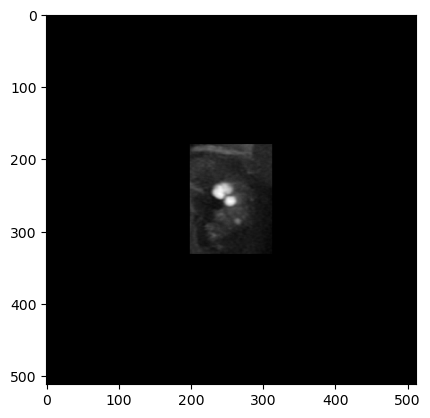

In [38]:
n=4
X_img = X[n,:,:,0]
X_msk =X[n,:,:,1] 
print(X_img.shape, X_img.max(), X_img.min())
print(X_msk.shape, X_msk.max(), X_msk.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

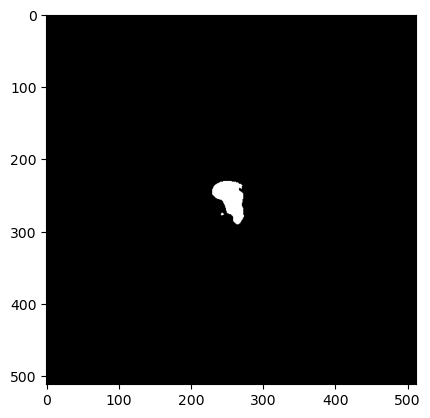

In [39]:
%matplotlib inline
plt.imshow(X_msk, cmap="gray")

(512, 512) 1.0 0.0


<Figure size 640x480 with 0 Axes>

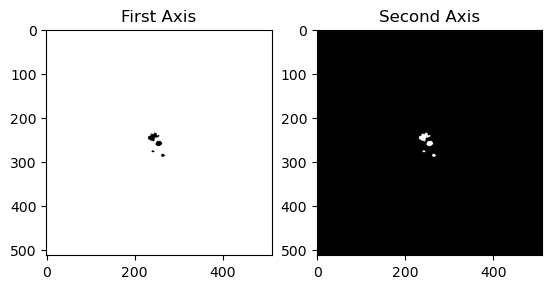

In [40]:
y_batch = y[n,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

In [42]:
model = custom_unet(input_shape=(512,512,2), num_classes=2)
#model.summary()

In [43]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [44]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
model_name = "cyst_seg_80-10_split_35epoch.h5"
filepath = model_name
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
cb = TimingCallback()

In [45]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [47]:
# Train model on dataset
history = model.fit(training_generator, epochs = 15,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[cb])

Epoch 1/15
1885/1885 [==============================] - 2788s 1s/step - loss: 0.2361 - dice_coef: 0.8778 - val_loss: 0.0142 - val_dice_coef: 0.9928
Epoch 2/15
1885/1885 [==============================] - 2866s 2s/step - loss: 0.0155 - dice_coef: 0.9922 - val_loss: 0.0056 - val_dice_coef: 0.9971
Epoch 3/15
1885/1885 [==============================] - 2885s 2s/step - loss: 0.0053 - dice_coef: 0.9973 - val_loss: 0.0031 - val_dice_coef: 0.9984
Epoch 4/15
1885/1885 [==============================] - 2897s 2s/step - loss: 0.0033 - dice_coef: 0.9983 - val_loss: 0.0026 - val_dice_coef: 0.9987
Epoch 5/15
1885/1885 [==============================] - 2873s 2s/step - loss: 0.0030 - dice_coef: 0.9985 - val_loss: 0.0025 - val_dice_coef: 0.9987
Epoch 6/15
1885/1885 [==============================] - 2879s 2s/step - loss: 0.0024 - dice_coef: 0.9988 - val_loss: 0.0024 - val_dice_coef: 0.9988
Epoch 7/15
1885/1885 [==============================] - 2878s 2s/step - loss: 0.0021 - dice_coef: 0.9989 - val_l

In [48]:
print(cb.logs)
print(sum(cb.logs))

[2788.3673413, 2866.4222959999997, 2884.6249012, 2896.7705179999994, 2872.5277575, 2878.5599895999985, 2877.9465337, 2853.464579299998, 2870.388093399997, 2873.289286899999, 2874.912786500001, 2888.8810061000004, 2896.3331143999967, 2870.8955971999967, 2860.2982195000004]
43053.68202059999


In [49]:
sum(cb.logs)/3600

11.95935611683333

In [50]:
time = list(cb.logs)
print(time)

[2788.3673413, 2866.4222959999997, 2884.6249012, 2896.7705179999994, 2872.5277575, 2878.5599895999985, 2877.9465337, 2853.464579299998, 2870.388093399997, 2873.289286899999, 2874.912786500001, 2888.8810061000004, 2896.3331143999967, 2870.8955971999967, 2860.2982195000004]


In [51]:
import pandas as pd
df = pd.DataFrame.from_dict(history.history)

In [52]:
df['epoch_time'] = np.array(cb.logs)

In [53]:
df.to_csv('cyst_seg_80-10_split_35epoch_corrected.csv')

In [54]:
import pandas as pd

DF = pd.read_csv('cyst_seg_80-10_split_35epoch.csv')

print(DF) 

    Unnamed: 0      loss  dice_coef  val_loss  val_dice_coef  epoch_time
0            0  0.187561   0.903353  0.019181       0.990254  730.477261
1            1  0.013462   0.993162  0.007548       0.996158  723.231615
2            2  0.006855   0.996509  0.005741       0.997075  725.348534
3            3  0.005252   0.997323  0.004934       0.997485  725.013333
4            4  0.004498   0.997707  0.004831       0.997536  725.431016
5            5  0.004044   0.997937  0.004877       0.997516  734.460748
6            6  0.003688   0.998121  0.004904       0.997498  732.930016
7            7  0.003454   0.998237  0.004480       0.997715  722.999116
8            8  0.003250   0.998343  0.004466       0.997722  723.291316
9            9  0.003100   0.998419  0.004351       0.997781  723.626888
10          10  0.002934   0.998504  0.004331       0.997791  728.792869
11          11  0.002813   0.998566  0.004410       0.997751  732.290947
12          12  0.002703   0.998622  0.004321      

In [55]:
from keras.models import Sequential, load_model
model.save(model_name)    

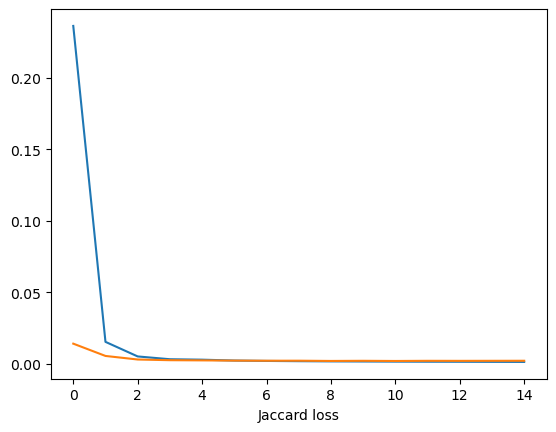

In [56]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

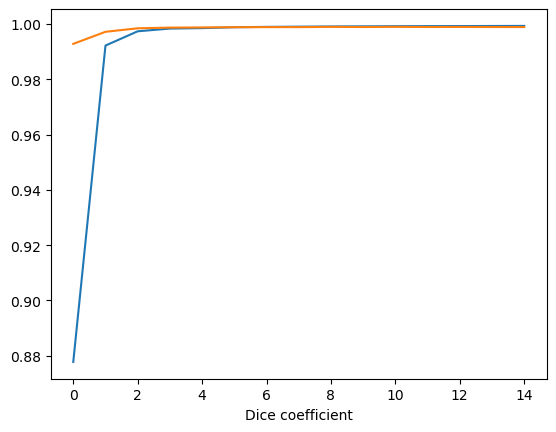

In [57]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')